# **Data Import :**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Teeth_DataSet.zip to Teeth_DataSet.zip


In [ ]:
import zipfile
import os

with zipfile.ZipFile("Teeth_DataSet.zip", 'r') as zip_ref:
    zip_ref.extractall("Teeth_DataSet")

os.listdir("Teeth_DataSet")


['Teeth DataSet']

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/Teeth_DataSet/Teeth_DataSet/Teeth_Dataset/Training'
val_dir = '/content/Teeth_DataSet/Teeth_DataSet/Teeth_Dataset/Validation'
test_dir = '/content/Teeth_DataSet/Teeth_DataSet/Teeth_Dataset/Testing'

# **EDA :**

In [ ]:
#Checking data structure

print("Checking Data Structure:")
train_classes = os.listdir(train_dir)
test_classes = os.listdir(test_dir)

print("Train Classes:", train_classes)
print("Test Classes:", test_classes)

Checking Data Structure:
Train Classes: ['MC', 'CaS', 'Gum', 'OT', 'CoS', 'OC', 'OLP']
Test Classes: ['MC', 'CaS', 'Gum', 'OT', 'CoS', 'OC', 'OLP']


/tmp/ipython-input-5-4094571264.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


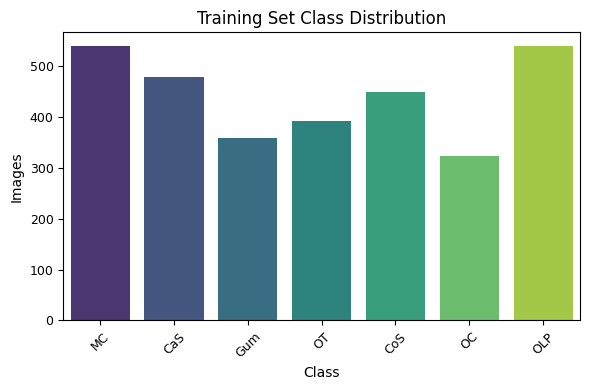

/tmp/ipython-input-5-4094571264.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


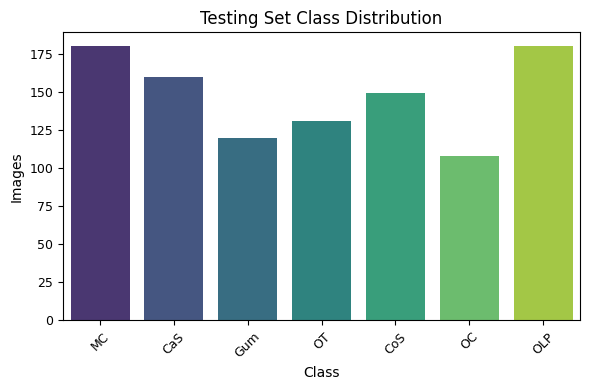

/tmp/ipython-input-5-4094571264.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


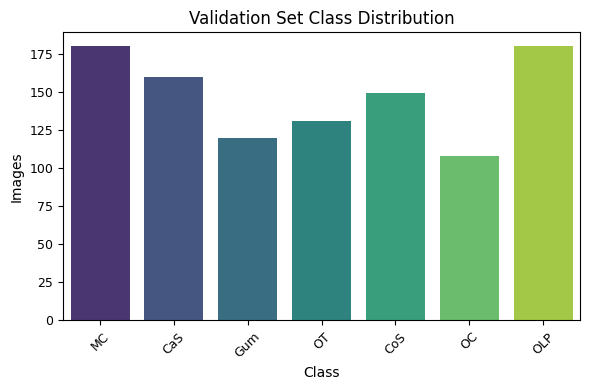

In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Function to count images per class
def get_class_counts(directory):
    counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
            counts[class_name] = count
    return counts

# Plotting function with smaller figure size
def plot_distribution(counts_dict, title):
    plt.figure(figsize=(6, 4))
    sns.barplot(
        x=list(counts_dict.keys()),
        y=list(counts_dict.values()),
        palette="viridis"
    )
    plt.title(title, fontsize=12)
    plt.ylabel("Images", fontsize=10)
    plt.xlabel("Class", fontsize=10)
    plt.xticks(rotation=45, fontsize=9)
    plt.yticks(fontsize=9)
    plt.tight_layout()
    plt.show()

# Get and plot counts
plot_distribution(get_class_counts(train_dir), "Training Set Class Distribution")
plot_distribution(get_class_counts(test_dir), "Testing Set Class Distribution")
plot_distribution(get_class_counts(val_dir), "Validation Set Class Distribution")


# **Preprocessing :**

In [ ]:
# Generator for Training DataSet: Augmentation + Normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalization
    rotation_range=30,            # تدوير
    width_shift_range=0.2,        # إزاحة عرضية
    height_shift_range=0.2,       # إزاحة طولية
    shear_range=0.2,              # قص
    zoom_range=0.2,               # تكبير/تصغير
    horizontal_flip=True,         # قلب أفقي
    fill_mode='nearest'           # ملء الفراغات
)

# Generator for Testing & Validation : Normalization
val_test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
# Load the Data :
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


Found 3087 images belonging to 7 classes.


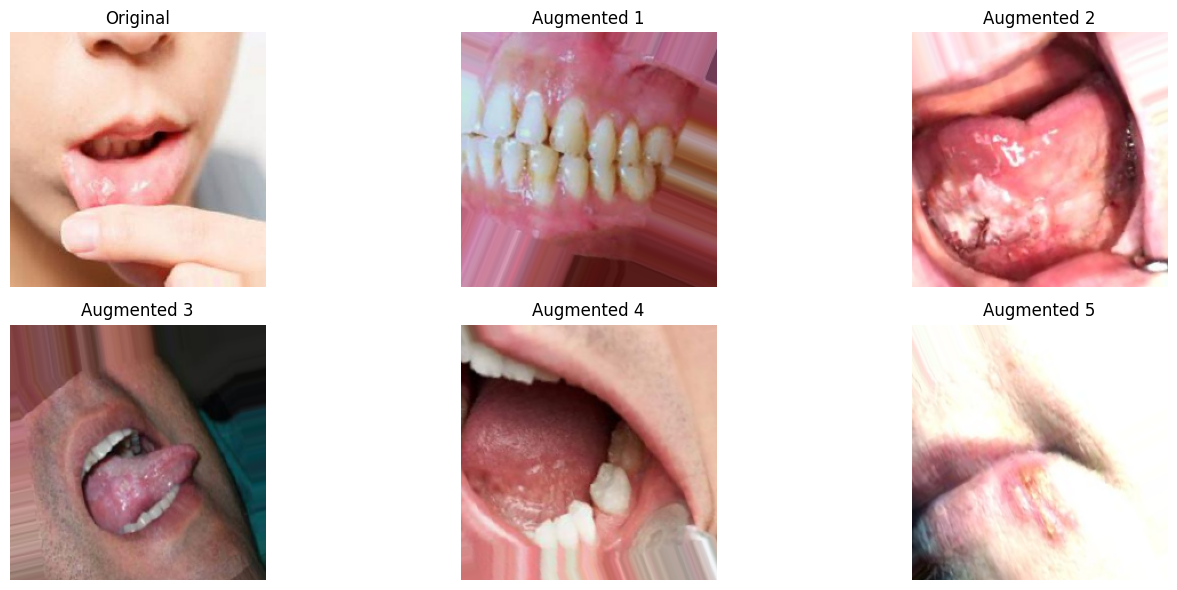

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Take an image from Training (WITHOUT Augmentation)
original_generator = ImageDataGenerator(rescale=1./255)
original_sample = original_generator.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Take the same image from Training (WITH Augmentation)
augmented_sample = train_generator


original_image, _ = next(original_sample)
original_image = original_image[0]

# Take 5 Augmented copies of the same image
augmented_images = [original_image]
for _ in range(5):
    img_batch, _ = next(augmented_sample)
    augmented_images.append(img_batch[0])


plt.figure(figsize=(15, 6))
for i, img in enumerate(augmented_images):
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title("Original" if i == 0 else f"Augmented {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# استيراد الدالة المطلوبة
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# حساب class weights بعد تعريف train_generator
class_names = list(train_generator.class_indices.keys())
labels = train_generator.classes

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(0.91875), 1: np.float64(0.98), 2: np.float64(1.225), 3: np.float64(0.8166666666666667), 4: np.float64(1.3611111111111112), 5: np.float64(0.8166666666666667), 6: np.float64(1.1221374045801527)}


# **Modeling :**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [ ]:
# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')  # Output layer
])


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,861,575 (37.62 MB)

 Trainable params: 9,860,615 (37.62 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Define early stopping and reduce_lr & model checkpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

checkpoint = ModelCheckpoint("best_model_scratch.h5", monitor="val_accuracy", save_best_only=True)


# Train the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint, reduce_lr],
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.2026 - loss: 2.9411

97/97 ━━━━━━━━━━━━━━━━━━━━ 59s 481ms/step - accuracy: 0.2029 - loss: 2.9360 - val_accuracy: 0.1449 - val_loss: 8.9603 - learning_rate: 1.0000e-04
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 47s 486ms/step - accuracy: 0.2556 - loss: 1.9039 - val_accuracy: 0.1449 - val_loss: 14.2223 - learning_rate: 1.0000e-04
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 447ms/step - accuracy: 0.2855 - loss: 1.8189 - val_accuracy: 0.1449 - val_loss: 12.1004 - learning_rate: 1.0000e-04
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 47s 486ms/step - accuracy: 0.3144 - loss: 1.7801 - val_accuracy: 0.1449 - val_loss: 7.3311 - learning_rate: 1.0000e-04
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.3169 - loss: 1.7168

97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 415ms/step - accuracy: 0.3168 - loss: 1.7169 - val_accuracy: 0.2461 - val_loss: 2.2642 - learning_rate: 1.0000e-04
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.3161 - loss: 1.7661

97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 405ms/step - accuracy: 0.3162 - loss: 1.7655 - val_accuracy: 0.4008 - val_loss: 1.5941 - learning_rate: 1.0000e-04
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.3296 - loss: 1.6884

97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 409ms/step - accuracy: 0.3295 - loss: 1.6886 - val_accuracy: 0.4825 - val_loss: 1.4309 - learning_rate: 1.0000e-04
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.3447 - loss: 1.6881

97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 399ms/step - accuracy: 0.3447 - loss: 1.6880 - val_accuracy: 0.4835 - val_loss: 1.3839 - learning_rate: 1.0000e-04
Epoch 9/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 402ms/step - accuracy: 0.3429 - loss: 1.6539 - val_accuracy: 0.4805 - val_loss: 1.4069 - learning_rate: 1.0000e-04
Epoch 10/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 400ms/step - accuracy: 0.3375 - loss: 1.6965 - val_accuracy: 0.3560 - val_loss: 1.5975 - learning_rate: 1.0000e-04
Epoch 11/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 395ms/step - accuracy: 0.3381 - loss: 1.6644 - val_accuracy: 0.4776 - val_loss: 1.3832 - learning_rate: 1.0000e-04
Epoch 12/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 395ms/step - accuracy: 0.3905 - loss: 1.6180 - val_accuracy: 0.4465 - val_loss: 1.4549 - learning_rate: 1.0000e-04
Epoch 13/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 398ms/step - accuracy: 0.3724 - loss: 1.6231 - val_accuracy: 0.4767 - val_loss: 1.4093 - learning_rate: 1.0000e-04
Epoch 14/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accu

97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 397ms/step - accuracy: 0.3946 - loss: 1.5666 - val_accuracy: 0.5263 - val_loss: 1.2835 - learning_rate: 5.0000e-05
Epoch 16/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.4203 - loss: 1.5001

97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 395ms/step - accuracy: 0.4203 - loss: 1.4999 - val_accuracy: 0.6021 - val_loss: 1.1568 - learning_rate: 5.0000e-05
Epoch 17/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 395ms/step - accuracy: 0.4703 - loss: 1.4282 - val_accuracy: 0.6002 - val_loss: 1.1161 - learning_rate: 5.0000e-05
Epoch 18/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 398ms/step - accuracy: 0.4454 - loss: 1.4631 - val_accuracy: 0.5914 - val_loss: 1.1200 - learning_rate: 5.0000e-05
Epoch 19/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 394ms/step - accuracy: 0.4717 - loss: 1.3886 - val_accuracy: 0.5661 - val_loss: 1.1338 - learning_rate: 5.0000e-05
Epoch 20/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.4610 - loss: 1.4085

97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 407ms/step - accuracy: 0.4610 - loss: 1.4086 - val_accuracy: 0.6304 - val_loss: 1.0458 - learning_rate: 5.0000e-05
Epoch 21/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.4477 - loss: 1.4315

97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 402ms/step - accuracy: 0.4479 - loss: 1.4310 - val_accuracy: 0.6498 - val_loss: 1.0434 - learning_rate: 5.0000e-05
Epoch 22/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 395ms/step - accuracy: 0.4536 - loss: 1.4013 - val_accuracy: 0.5885 - val_loss: 1.0987 - learning_rate: 5.0000e-05
Epoch 23/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 394ms/step - accuracy: 0.4766 - loss: 1.3781 - val_accuracy: 0.6158 - val_loss: 1.0511 - learning_rate: 5.0000e-05
Epoch 24/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.4888 - loss: 1.3127

97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 416ms/step - accuracy: 0.4887 - loss: 1.3132 - val_accuracy: 0.6654 - val_loss: 0.9789 - learning_rate: 5.0000e-05
Epoch 25/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 396ms/step - accuracy: 0.5070 - loss: 1.3224 - val_accuracy: 0.6644 - val_loss: 0.9618 - learning_rate: 5.0000e-05
Epoch 26/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.4983 - loss: 1.3134

97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 412ms/step - accuracy: 0.4983 - loss: 1.3136 - val_accuracy: 0.7091 - val_loss: 0.9129 - learning_rate: 5.0000e-05
Epoch 27/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 394ms/step - accuracy: 0.4978 - loss: 1.3329 - val_accuracy: 0.6547 - val_loss: 0.9775 - learning_rate: 5.0000e-05
Epoch 28/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 398ms/step - accuracy: 0.4958 - loss: 1.3210 - val_accuracy: 0.6537 - val_loss: 0.9319 - learning_rate: 5.0000e-05
Epoch 29/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.5239 - loss: 1.2652

97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 411ms/step - accuracy: 0.5239 - loss: 1.2654 - val_accuracy: 0.7101 - val_loss: 0.8994 - learning_rate: 5.0000e-05
Epoch 30/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 405ms/step - accuracy: 0.5350 - loss: 1.2887 - val_accuracy: 0.6848 - val_loss: 0.8908 - learning_rate: 5.0000e-05
Epoch 31/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 391ms/step - accuracy: 0.5348 - loss: 1.2478 - val_accuracy: 0.7004 - val_loss: 0.8802 - learning_rate: 5.0000e-05
Epoch 32/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 394ms/step - accuracy: 0.5297 - loss: 1.2534 - val_accuracy: 0.6907 - val_loss: 0.8853 - learning_rate: 5.0000e-05
Epoch 33/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.5407 - loss: 1.2342

97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 396ms/step - accuracy: 0.5407 - loss: 1.2343 - val_accuracy: 0.7150 - val_loss: 0.8344 - learning_rate: 5.0000e-05
Epoch 34/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.5349 - loss: 1.1997

97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 397ms/step - accuracy: 0.5349 - loss: 1.1999 - val_accuracy: 0.7364 - val_loss: 0.7794 - learning_rate: 5.0000e-05
Epoch 35/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.5630 - loss: 1.1873

97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 399ms/step - accuracy: 0.5629 - loss: 1.1872 - val_accuracy: 0.7442 - val_loss: 0.7752 - learning_rate: 5.0000e-05
Epoch 36/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 391ms/step - accuracy: 0.5723 - loss: 1.1571 - val_accuracy: 0.7150 - val_loss: 0.8331 - learning_rate: 5.0000e-05
Epoch 37/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.5624 - loss: 1.1821

97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 409ms/step - accuracy: 0.5623 - loss: 1.1822 - val_accuracy: 0.7578 - val_loss: 0.7566 - learning_rate: 5.0000e-05
Epoch 38/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 399ms/step - accuracy: 0.5689 - loss: 1.1695 - val_accuracy: 0.7393 - val_loss: 0.7667 - learning_rate: 5.0000e-05
Epoch 39/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 399ms/step - accuracy: 0.5722 - loss: 1.1560 - val_accuracy: 0.7500 - val_loss: 0.7508 - learning_rate: 5.0000e-05
Epoch 40/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 408ms/step - accuracy: 0.5749 - loss: 1.1172 - val_accuracy: 0.7490 - val_loss: 0.7282 - learning_rate: 5.0000e-05
Epoch 41/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.5772 - loss: 1.1368

97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 398ms/step - accuracy: 0.5772 - loss: 1.1368 - val_accuracy: 0.7675 - val_loss: 0.6961 - learning_rate: 5.0000e-05
Epoch 42/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 394ms/step - accuracy: 0.5744 - loss: 1.1238 - val_accuracy: 0.7626 - val_loss: 0.6907 - learning_rate: 5.0000e-05
Epoch 43/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 398ms/step - accuracy: 0.5686 - loss: 1.1369 - val_accuracy: 0.6722 - val_loss: 0.9312 - learning_rate: 5.0000e-05
Epoch 44/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 395ms/step - accuracy: 0.5899 - loss: 1.1224 - val_accuracy: 0.7519 - val_loss: 0.7046 - learning_rate: 5.0000e-05
Epoch 45/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.6191 - loss: 1.0430

97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 401ms/step - accuracy: 0.6190 - loss: 1.0430 - val_accuracy: 0.7860 - val_loss: 0.6393 - learning_rate: 5.0000e-05
Epoch 46/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 408ms/step - accuracy: 0.6131 - loss: 1.0601 - val_accuracy: 0.7704 - val_loss: 0.6934 - learning_rate: 5.0000e-05
Epoch 47/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.6082 - loss: 1.0662

97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 398ms/step - accuracy: 0.6082 - loss: 1.0661 - val_accuracy: 0.7928 - val_loss: 0.6260 - learning_rate: 5.0000e-05
Epoch 48/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 408ms/step - accuracy: 0.6158 - loss: 1.0291 - val_accuracy: 0.7704 - val_loss: 0.6412 - learning_rate: 5.0000e-05
Epoch 49/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.6273 - loss: 1.0495

97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 400ms/step - accuracy: 0.6274 - loss: 1.0494 - val_accuracy: 0.8084 - val_loss: 0.6168 - learning_rate: 5.0000e-05
Epoch 50/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 398ms/step - accuracy: 0.6217 - loss: 1.0591 - val_accuracy: 0.8006 - val_loss: 0.5913 - learning_rate: 5.0000e-05
Epoch 51/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.6345 - loss: 1.0145

97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 410ms/step - accuracy: 0.6344 - loss: 1.0148 - val_accuracy: 0.8142 - val_loss: 0.6086 - learning_rate: 5.0000e-05
Epoch 52/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 396ms/step - accuracy: 0.6335 - loss: 1.0079 - val_accuracy: 0.6975 - val_loss: 0.9118 - learning_rate: 5.0000e-05
Epoch 53/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.6362 - loss: 0.9779

97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 402ms/step - accuracy: 0.6363 - loss: 0.9780 - val_accuracy: 0.8278 - val_loss: 0.5473 - learning_rate: 5.0000e-05
Epoch 54/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 394ms/step - accuracy: 0.6484 - loss: 0.9723 - val_accuracy: 0.7792 - val_loss: 0.6459 - learning_rate: 5.0000e-05
Epoch 55/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.6440 - loss: 0.9668

97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 401ms/step - accuracy: 0.6440 - loss: 0.9668 - val_accuracy: 0.8444 - val_loss: 0.5086 - learning_rate: 5.0000e-05
Epoch 56/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 394ms/step - accuracy: 0.6567 - loss: 0.9738 - val_accuracy: 0.8317 - val_loss: 0.5478 - learning_rate: 5.0000e-05
Epoch 57/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 396ms/step - accuracy: 0.6573 - loss: 0.9580 - val_accuracy: 0.8113 - val_loss: 0.5612 - learning_rate: 5.0000e-05
Epoch 58/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.6672 - loss: 0.8847
Epoch 58: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 394ms/step - accuracy: 0.6671 - loss: 0.8850 - val_accuracy: 0.8444 - val_loss: 0.5236 - learning_rate: 5.0000e-05
Epoch 59/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 394ms/step - accuracy: 0.6683 - loss: 0.9047 - val_accuracy: 0.8317 - val_loss: 0.5222 - learning_rate: 2.5000e-05
Epoch 60/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 

97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 415ms/step - accuracy: 0.6787 - loss: 0.8733 - val_accuracy: 0.8677 - val_loss: 0.4629 - learning_rate: 2.5000e-05
Epoch 61/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 396ms/step - accuracy: 0.7023 - loss: 0.8137 - val_accuracy: 0.8531 - val_loss: 0.4530 - learning_rate: 2.5000e-05
Epoch 62/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 395ms/step - accuracy: 0.6968 - loss: 0.8193 - val_accuracy: 0.8628 - val_loss: 0.4465 - learning_rate: 2.5000e-05
Epoch 63/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.6969 - loss: 0.8285

97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 397ms/step - accuracy: 0.6968 - loss: 0.8287 - val_accuracy: 0.8804 - val_loss: 0.4017 - learning_rate: 2.5000e-05
Epoch 64/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 399ms/step - accuracy: 0.6996 - loss: 0.8017 - val_accuracy: 0.8395 - val_loss: 0.4992 - learning_rate: 2.5000e-05
Epoch 65/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 398ms/step - accuracy: 0.6993 - loss: 0.7987 - val_accuracy: 0.8648 - val_loss: 0.4266 - learning_rate: 2.5000e-05
Epoch 66/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.6919 - loss: 0.8526
Epoch 66: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 400ms/step - accuracy: 0.6919 - loss: 0.8526 - val_accuracy: 0.8473 - val_loss: 0.4743 - learning_rate: 2.5000e-05
Epoch 67/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 392ms/step - accuracy: 0.7175 - loss: 0.8042 - val_accuracy: 0.8794 - val_loss: 0.4003 - learning_rate: 1.2500e-05
Epoch 68/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 398ms/step - accuracy:

97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 400ms/step - accuracy: 0.7022 - loss: 0.8039 - val_accuracy: 0.8988 - val_loss: 0.3632 - learning_rate: 1.2500e-05
Epoch 71/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 408ms/step - accuracy: 0.7138 - loss: 0.7711 - val_accuracy: 0.8959 - val_loss: 0.3485 - learning_rate: 1.2500e-05
Epoch 72/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 397ms/step - accuracy: 0.7275 - loss: 0.7659 - val_accuracy: 0.8823 - val_loss: 0.3948 - learning_rate: 1.2500e-05
Epoch 73/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 397ms/step - accuracy: 0.7378 - loss: 0.7348 - val_accuracy: 0.8804 - val_loss: 0.4048 - learning_rate: 1.2500e-05
Epoch 74/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.7283 - loss: 0.7487
Epoch 74: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 393ms/step - accuracy: 0.7284 - loss: 0.7487 - val_accuracy: 0.8920 - val_loss: 0.3781 - learning_rate: 1.2500e-05
Epoch 75/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 397ms/step - accuracy: 

97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 406ms/step - accuracy: 0.7255 - loss: 0.7342 - val_accuracy: 0.9095 - val_loss: 0.3332 - learning_rate: 6.2500e-06
Epoch 77/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 403ms/step - accuracy: 0.7332 - loss: 0.7458 - val_accuracy: 0.9027 - val_loss: 0.3502 - learning_rate: 6.2500e-06
Epoch 78/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 392ms/step - accuracy: 0.7372 - loss: 0.7211 - val_accuracy: 0.8920 - val_loss: 0.3780 - learning_rate: 6.2500e-06
Epoch 79/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.7267 - loss: 0.7601
Epoch 79: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 394ms/step - accuracy: 0.7267 - loss: 0.7598 - val_accuracy: 0.9086 - val_loss: 0.3448 - learning_rate: 6.2500e-06
Epoch 80/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.7427 - loss: 0.7350

97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 398ms/step - accuracy: 0.7428 - loss: 0.7348 - val_accuracy: 0.9125 - val_loss: 0.3401 - learning_rate: 3.1250e-06
Epoch 81/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.7283 - loss: 0.7182

97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 400ms/step - accuracy: 0.7284 - loss: 0.7180 - val_accuracy: 0.9144 - val_loss: 0.3285 - learning_rate: 3.1250e-06
Epoch 82/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.7427 - loss: 0.7132

97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 396ms/step - accuracy: 0.7427 - loss: 0.7134 - val_accuracy: 0.9154 - val_loss: 0.3278 - learning_rate: 3.1250e-06
Epoch 83/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 415ms/step - accuracy: 0.7439 - loss: 0.7097 - val_accuracy: 0.9125 - val_loss: 0.3382 - learning_rate: 3.1250e-06
Epoch 84/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 392ms/step - accuracy: 0.7258 - loss: 0.7388 - val_accuracy: 0.9037 - val_loss: 0.3509 - learning_rate: 3.1250e-06
Epoch 85/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.7511 - loss: 0.6806
Epoch 85: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 401ms/step - accuracy: 0.7510 - loss: 0.6808 - val_accuracy: 0.9154 - val_loss: 0.3369 - learning_rate: 3.1250e-06
Epoch 86/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 403ms/step - accuracy: 0.7547 - loss: 0.6656 - val_accuracy: 0.9134 - val_loss: 0.3341 - learning_rate: 1.5625e-06
Epoch 87/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0

97/97 ━━━━━━━━━━━━━━━━━━━━ 38s 394ms/step - accuracy: 0.7285 - loss: 0.7188 - val_accuracy: 0.9163 - val_loss: 0.3204 - learning_rate: 1.5625e-06
Epoch 88/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 396ms/step - accuracy: 0.7589 - loss: 0.6858 - val_accuracy: 0.9163 - val_loss: 0.3263 - learning_rate: 1.5625e-06
Epoch 89/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 392ms/step - accuracy: 0.7578 - loss: 0.6566 - val_accuracy: 0.9154 - val_loss: 0.3345 - learning_rate: 1.5625e-06
Epoch 90/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.7561 - loss: 0.6822
Epoch 90: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 406ms/step - accuracy: 0.7561 - loss: 0.6823 - val_accuracy: 0.9125 - val_loss: 0.3383 - learning_rate: 1.5625e-06
Epoch 91/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 406ms/step - accuracy: 0.7512 - loss: 0.6924 - val_accuracy: 0.9125 - val_loss: 0.3338 - learning_rate: 7.8125e-07
Epoch 92/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 398ms/step - accuracy: 

In [ ]:
# Evaluate the model

train_loss, train_accuracy = model.evaluate(train_generator)
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


97/97 ━━━━━━━━━━━━━━━━━━━━ 36s 367ms/step - accuracy: 0.8811 - loss: 0.4038
Train Loss: 0.4182
Train Accuracy: 0.8798
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9393 - loss: 0.2936
Test Loss: 0.2953
Test Accuracy: 0.9212


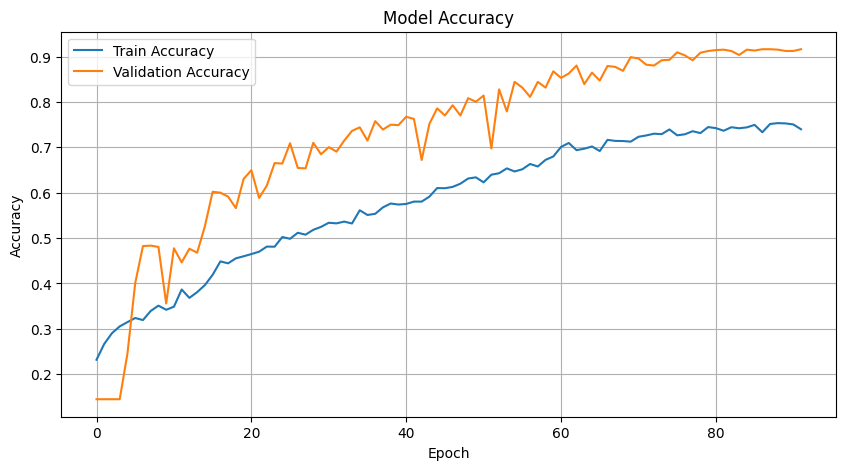

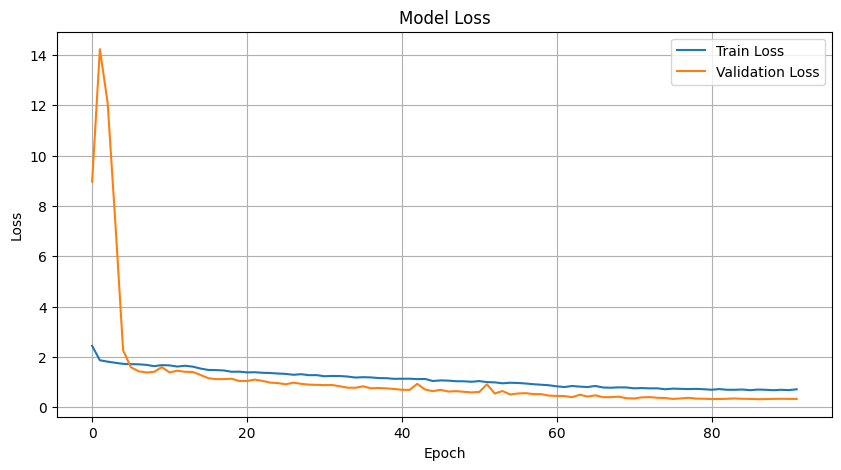

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


<Figure size 1000x800 with 0 Axes>

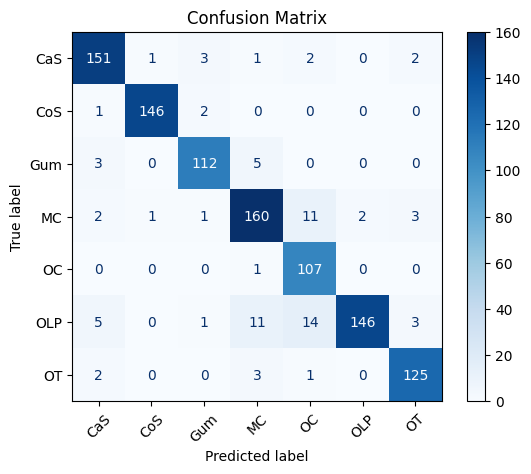

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()



In [ ]:
from sklearn.metrics import classification_report, accuracy_score

print("Classification Report")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

print("Accuracy:", accuracy_score(y_true, y_pred))


Classification Report
              precision    recall  f1-score   support

         CaS       0.92      0.94      0.93       160
         CoS       0.99      0.98      0.98       149
         Gum       0.94      0.93      0.94       120
          MC       0.88      0.89      0.89       180
          OC       0.79      0.99      0.88       108
         OLP       0.99      0.81      0.89       180
          OT       0.94      0.95      0.95       131

    accuracy                           0.92      1028
   macro avg       0.92      0.93      0.92      1028
weighted avg       0.93      0.92      0.92      1028

Accuracy: 0.9212062256809338


Testing code


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


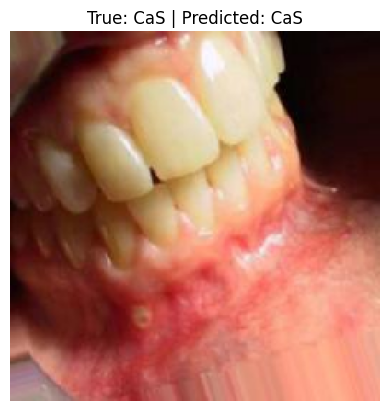

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


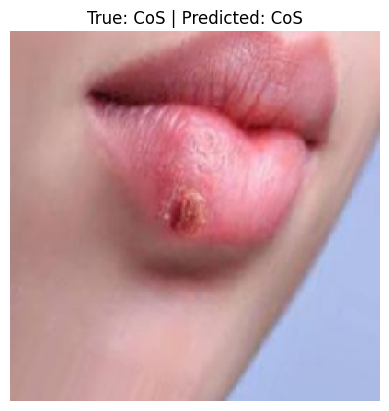

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


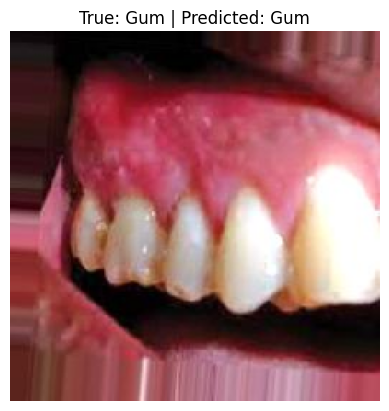

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


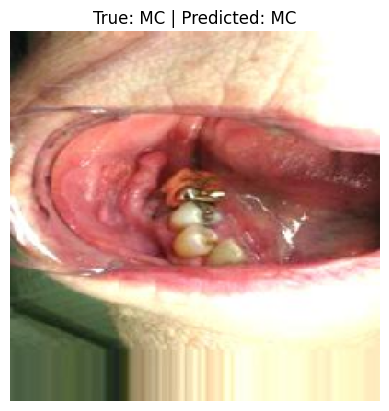

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


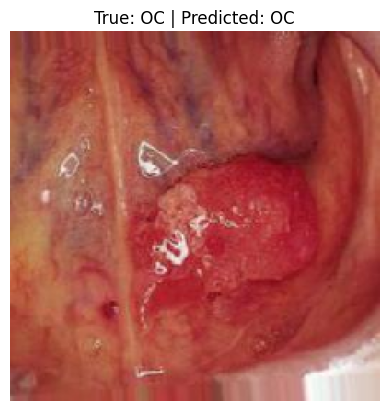

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


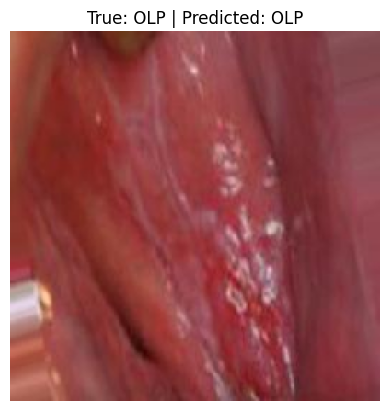

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


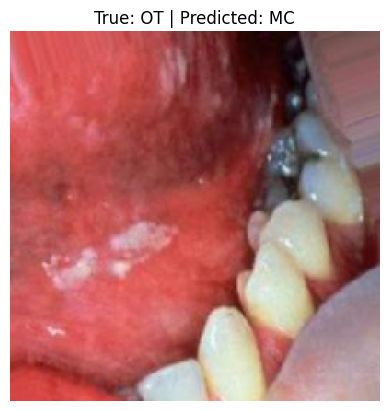

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

model = load_model('best_model_scratch.h5')

# Set parameters

test_dir = '/content/Teeth_DataSet/Teeth_DataSet/Teeth_Dataset/Testing'
class_names = sorted(os.listdir(test_dir))  # get class names

# Loop over each class and predict one image
for class_name in class_names:
    class_path = os.path.join(test_dir, class_name)
    image_files = os.listdir(class_path)

    if not image_files:
        print(f"No images in {class_name}, skipping.")
        continue

    # Pick the first image in the folder
    img_path = os.path.join(class_path, image_files[0])
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0  # normalize
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

    # Predict
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    # Display
    plt.imshow(img)
    plt.title(f"True: {class_name} | Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()


Grad-CAM

# **Modeling VGG :**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# --- Compute class weights based on train_generator ---
from sklearn.utils import class_weight
import numpy as np

class_indices = train_generator.class_indices
labels = train_generator.classes

class_weights = class_weight.compute_class_weight(
class_weight='balanced',
classes=np.unique(labels),
y=labels
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: np.float64(0.91875), 1: np.float64(0.98), 2: np.float64(1.225), 3: np.float64(0.8166666666666667), 4: np.float64(1.3611111111111112), 5: np.float64(0.8166666666666667), 6: np.float64(1.1221374045801527)}


In [ ]:
# Load the VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers except the last 20
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.002))(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.002))(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

# Define the full model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-7)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[early_stop, reduce_lr],
    class_weight= class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 97s 736ms/step - accuracy: 0.1638 - loss: 4.1972 - val_accuracy: 0.2928 - val_loss: 2.8495 - learning_rate: 1.0000e-05
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 102s 549ms/step - accuracy: 0.2437 - loss: 3.6539 - val_accuracy: 0.2685 - val_loss: 2.7892 - learning_rate: 1.0000e-05
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 551ms/step - accuracy: 0.2837 - loss: 3.4800 - val_accuracy: 0.4844 - val_loss: 2.4838 - learning_rate: 1.0000e-05
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 54s 559ms/step - accuracy: 0.3222 - loss: 3.2822 - val_accuracy: 0.4961 - val_loss: 2.3624 - learning_rate: 1.0000e-05
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 54s 557ms/step - accuracy: 0.3642 - loss: 3.0773 - val_accuracy: 0.5204 - val_loss: 2.2491 - learning_rate: 1.0000e-05
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 59s 602ms/step - accuracy: 0.3747 - loss: 3.0458 - val_accuracy: 0.5282 - val_loss: 2.3060 - learning_rate: 1.0000e-05
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 88s 667ms/step - ac

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Evaluate on test and train sets
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
train_loss, train_acc = model.evaluate(train_generator, verbose=1)

print(f"\nTrain Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}, Test Loss:  {test_loss:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.9872 - loss: 0.8312
97/97 ━━━━━━━━━━━━━━━━━━━━ 45s 464ms/step - accuracy: 0.9860 - loss: 0.8416

Train Accuracy: 0.9877, Train Loss: 0.8385
Test Accuracy:  0.9864, Test Loss:  0.8237


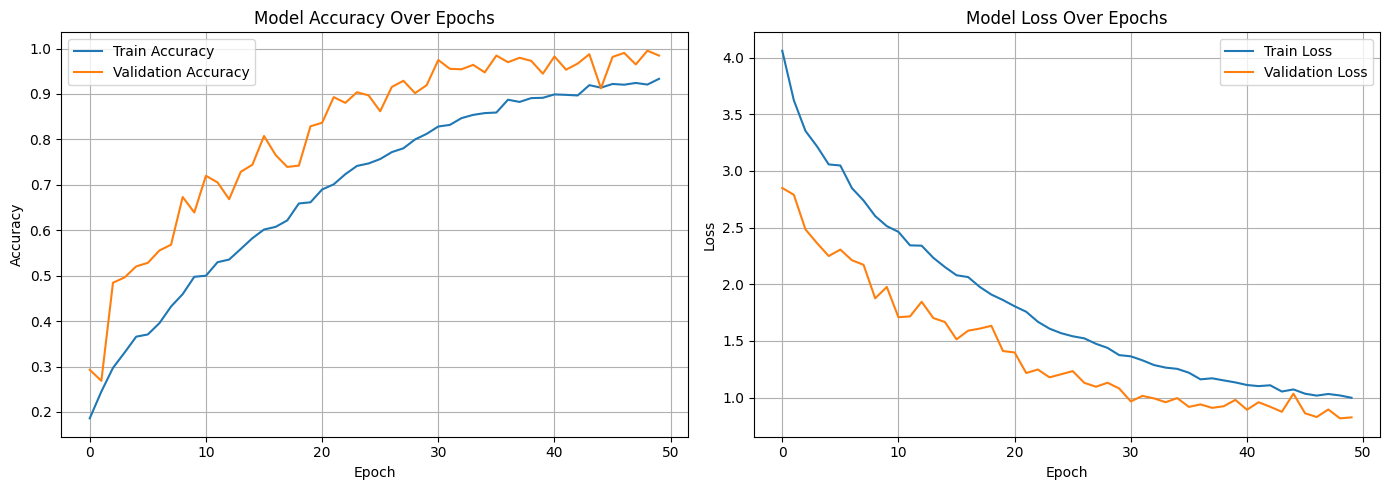

In [ ]:
# Plot accuracy and loss over epochs
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step


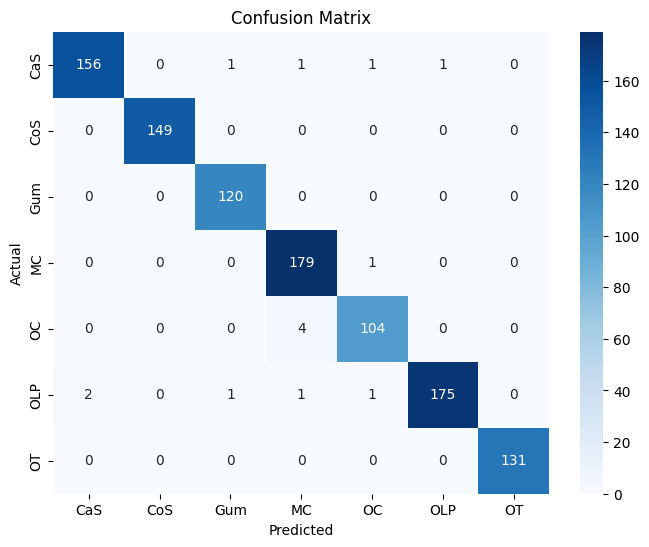


Classification Report:
               precision    recall  f1-score   support

         CaS     0.9873    0.9750    0.9811       160
         CoS     1.0000    1.0000    1.0000       149
         Gum     0.9836    1.0000    0.9917       120
          MC     0.9676    0.9944    0.9808       180
          OC     0.9720    0.9630    0.9674       108
         OLP     0.9943    0.9722    0.9831       180
          OT     1.0000    1.0000    1.0000       131

    accuracy                         0.9864      1028
   macro avg     0.9864    0.9864    0.9863      1028
weighted avg     0.9865    0.9864    0.9864      1028

Accuracy:  0.9864
Precision: 0.9865
Recall:    0.9864
F1 Score:  0.9864


In [ ]:
# Predictions
test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("\nClassification Report:\n", classification_report(true_classes, predicted_classes, target_names=class_labels, digits=4))

# Metrics
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')
accuracy = accuracy_score(true_classes, predicted_classes)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

In [ ]:
model.save("vgg_teeth_model.h5")

from google.colab import files
files.download("vgg_teeth_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Deplyment using streamlit :**

In [ ]:
#If the sesion closed:

from google.colab import files
files.upload()


Saving vgg_teeth_model.h5 to vgg_teeth_model.h5


In [ ]:
!pip install streamlit
!pip install pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.8 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

@st.cache_resource
def load_model_once():
    return load_model("vgg_teeth_model.h5")

model = load_model_once()

IMG_SIZE = (224, 224)
class_names = ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']

# Inject custom CSS for background color
st.markdown(
    """
    <style>
    .stApp {
        background-color: #ADD8E6;
    }
    </style>
    """,
    unsafe_allow_html=True
)

st.title("🦷 Teeth Classification with VGG16")
st.write("Upload a teeth image to classify.")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", width=300)

    # Preprocess
    img = image.resize(IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)

    st.markdown(f"### 🧠 Prediction: `{class_names[predicted_class]}`")
    st.markdown(f"Confidence: `{confidence:.2f}`")


Overwriting app.py


In [ ]:
from pyngrok import ngrok

ngrok.set_auth_token("2ziogsZnboFUwEDalhfVoIXNHYg_2SqEcYMcg8dVSWVT8qoyM")

In [ ]:
public_url = ngrok.connect(addr="8501", proto="http")
print(" Open the app ")
print(public_url)


!streamlit run app.py &


 Open the app 
NgrokTunnel: "https://a33f56b6b34d.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.29.135.246:8501

2025-07-11 09:41:11.357321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752226871.387435    9523 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752226871.396531    9523 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-11 09:41:16.669239: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOW